In [2]:
!pip install pandas numpy scikit-learn tensorflow

In [3]:
  import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
data = pd.read_csv("/content/weather_data.csv")
data.head()


,Temperature,Relative Humidity,Pressure
0,25.83,85.81,97.70
1,25.33,86.81,97.68
2,24.91,87.88,97.67
3,24.52,89.31,97.69
4,24.23,90.62,97.72


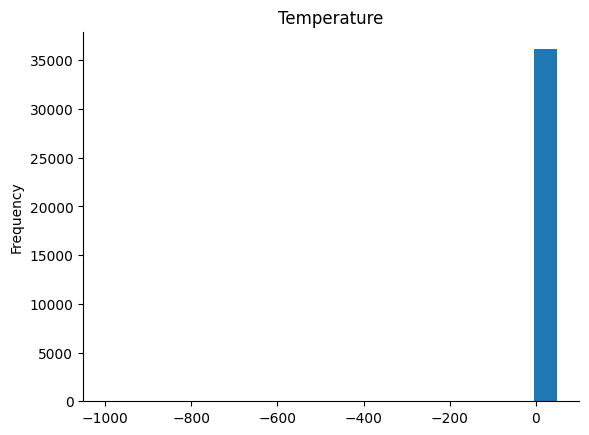

In [17]:
# @title Temperature

from matplotlib import pyplot as plt
data['Temperature'].plot(kind='hist', bins=20, title='Temperature')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
temperature_data = data[['Temperature']].values


In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
temperature_data = scaler.fit_transform(temperature_data)


In [10]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 30  # Number of days to look back
X, y = create_sequences(temperature_data, sequence_length)


In [11]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [12]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=50, batch_size=16, callbacks=[early_stopping])


Epoch 1/50
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - loss: 0.0536 - val_loss: 0.0017
Epoch 2/50
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 3.4326e-05 - val_loss: 0.0016
Epoch 3/50
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 3.3936e-05 - val_loss: 0.0015
Epoch 4/50
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 3.2134e-05 - val_loss: 0.0015
Epoch 5/50
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 3.4914e-05 - val_loss: 0.0014
Epoch 6/50
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 3.0131e-05 - val_loss: 0.0014
Epoch 7/50
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 2.9761e-05 - val_loss: 0.0014
Epoch 8/50
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 2.5854e-05 - val_loss: 0.0013
Epoch 9/50
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 2.5951e-05 - val_loss: 0.0013
Epoch 10/50
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 2.3809e-05 - val_loss: 0.0012
Epoch 11/50
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss

In [14]:
def forecast(model, last_sequence, n_days, scaler):
    predictions = []
    last_sequence = last_sequence[-sequence_length:]  # Take the last 30 days as input
    for _ in range(n_days):
        prediction = model.predict(last_sequence.reshape(1, sequence_length, 1))[0][0]
        predictions.append(prediction)
        # Update the sequence by adding the prediction and removing the first entry
        last_sequence = np.append(last_sequence[1:], prediction)
    # Inverse scale predictions to original values
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Predict the next 5 days
last_sequence = X_test[-1]  # Last observed sequence from the test set
predicted_temperatures = forecast(model, last_sequence, 5, scaler)
print(predicted_temperatures)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[19.06355 ]
 [19.802538]
 [21.150555]
 [23.154917]
 [25.68167 ]]


In [15]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)
mse = mean_squared_error(y_test_actual, y_pred)
print(f'Mean Squared Error: {mse}')


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Mean Squared Error: 740.3114465065914


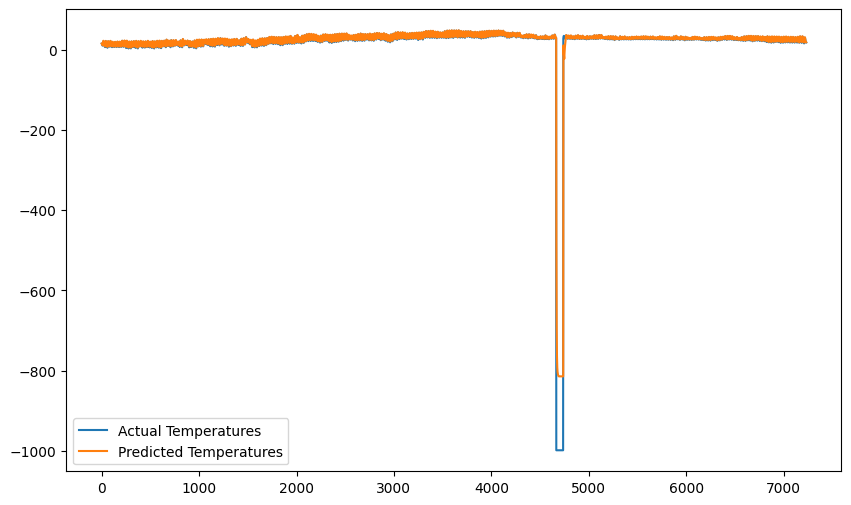

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label='Actual Temperatures')
plt.plot(range(len(y_test_actual)), y_pred, label='Predicted Temperatures')
plt.legend()
plt.show()


In [19]:
# saving the model
import pickle
with open('temperature_prediction_model.pkl', 'wb') as file:
    pickle.dump(model, file)
